CNN PARA LA CLASIFICACIÓN BINARIA DE IMÁGENES.

1. CONFIGUACIÓN E INSTALACIÓN DE LAS DEPENDENCIAS NECESARIAS PARA EL PROYECTO.

In [1]:
#Tenemos creado un enviromment en el que vamos a instalar los
#Packages necesarios para el correcto funcionamiento del proyecto.
!pip install tensorflow opencv-python matplotlib

  Using cached tensorflow-2.15.0-cp310-cp310-win_amd64.whl (2.1 kB)
  Using cached opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl (38.1 MB)
     ---------------------------------------- 7.6/7.6 MB 9.6 MB/s eta 0:00:00
  Using cached tensorflow_intel-2.15.0-cp310-cp310-win_amd64.whl (300.9 MB)
  Using cached protobuf-4.25.1-cp310-abi3-win_amd64.whl (413 kB)
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Using cached libclang-16.0.6-py2.py3-none-win_amd64.whl (24.4 MB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl (441 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-win_amd64.whl (1.5 MB)
  Using cached ml_dtypes-0.2.0-cp310-cp310-win_amd64.whl (938 kB)
  Using cached grpcio-1.60.0-cp310-cp310-win_amd64.whl (3.7 MB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached typing_extensions-4.9.0-py3-none-


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Importamos las dependencias que vamos a utilizar para el proyecto. 
import tensorflow as tf
import os 
import cv2
import imghdr

In [3]:
#Este código va a limitar el uso de la Vram para evitar inconvenientes relacionados con el uso excesivo de ésta.
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,true)

2. REMOVEMOS IMÁGENES QUE NO CUENTEN CON EL FORMATO INDICADO.

In [4]:
data_dir = "data"

In [5]:
image_exts = ["jpeg","jpg","bmp","png"]

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Imagen no cuenta con la extenión {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Ocurrió un problema con la imagen {}".format(image_path))

3. CARGAMOS LOS DATOS NECESARIOS PARA NUESTRO MODELO.

In [7]:
import numpy as np
from matplotlib import pyplot as plt

In [8]:
#Éste es un Pipeline de Keras que nos permite preprocesar las imágenes de una manera
#Mucho más rápida. Creando un dataset apartir de un directorio de imágenes,
#Creando características y labels para cada imagen. Además de redimensionarla.
#tf.keras.utils.image_dataset_from_directory?? -- Ver documentación.

data = tf.keras.utils.image_dataset_from_directory("data")

Found 192 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator() #Con éste código podemos acceder a los datos del pipeline creado anteriormente.

In [16]:
batch = data_iterator.next() #Este código toma un batch del iterador anteriormente ejecutado.
#El contenido de las imágenes como numpyArrays en la posición [0] y el contenido de la etiqueta en la posición[1]

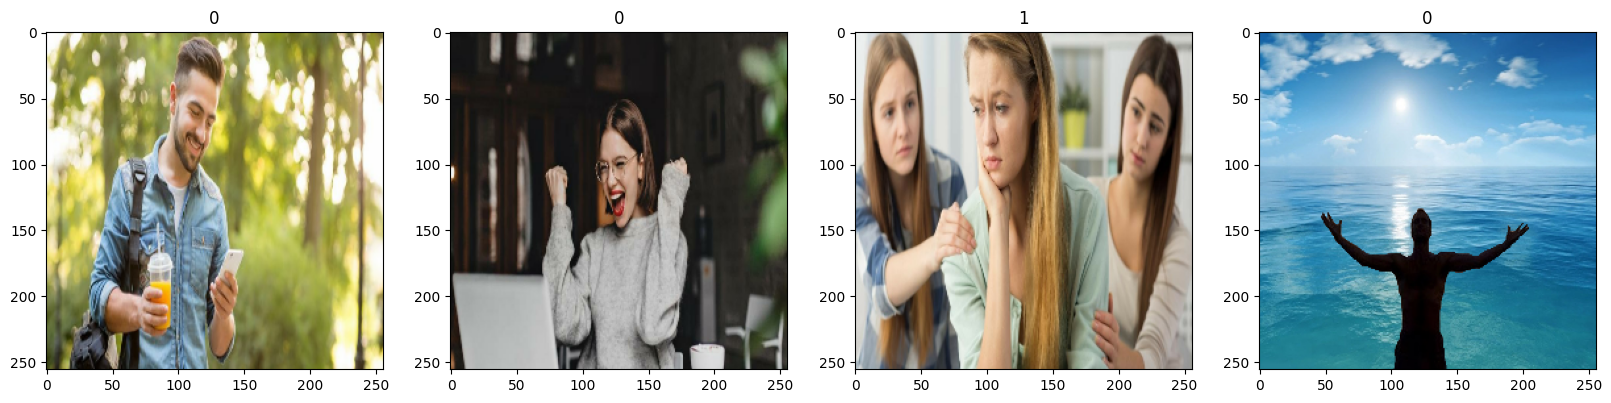

In [17]:
fig, ax = plt.subplots(ncols=4, figsize= (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
#Con éste código podemos ver cómo el pipeline está etiquetando nuestras imágenes de clasificación.
#Vemos que para las imágenes felices tenemos un label igual a 0 y 1 para las tristes.

4. PRE-PROCESAMIENTO DE LAS IMÁGENES.

In [19]:
#Algunos modelos de machine learning requieren que escalemos la información que ha de ingresar
#al sistema.
#Dividimos por 255 que son los valores máximos alcanzables en cada pixel de la imagen, 
#Para así llevarlo a una escala de valores entre 0 y 1

#Este es sólo un ejemplo: scaled = batch[0] / 255
#Sin embargo, éste código sólo modifica un batch del conjunto de datos obtenido por el pipeline.

#Debemos escalar todo el conjunto de datos. 

In [21]:
#Escalamos todos los datos obtenidos en nuestro pipeline, ya no por batches, sino todo el conjunto de datos.
data = data.map (lambda x, y: (x/255, y))

In [36]:
scaled_iterator = data.as_numpy_iterator()

In [47]:
batch = scaled_iterator.next()

In [48]:
batch [0].max()

1.0

5. DIVIDIENDO NUESTRO DATASET

In [49]:
#tenemos 6 batchs para el entrenamiento.
len(data)

6

In [56]:
train_size = int(len(data)*.7) #70% del total de los datos para entrenamiento.
val_size = int(len(data)*.2) #20% del total de los datos para validación.
test_size= int(len(data)*.1)+1 #10% del total de los datos para pruebas.

In [60]:
train = data.take(train_size)
val= data.skip(train_size).take(val_size)
test= data.skip(train_size+val_size).take(test_size)

6. CONSTRUCCIÓN DEL MODELO DE DEEP LEARNING

In [78]:
#Importamos las dependencias necesarias para la construcción del modelo.
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout #Capas del modelo.


In [79]:
model = Sequential() # Definimos el modelo.

In [80]:
#Configuramos la arquitectura del modelo - Capas.

#Capa convolucional y capa MaxPooling.
#16 filtros, (tamaño del filtro 3x3), 1 paso, función de activación reLU y condiciones de entrada de los datos.
#Nuestro pipeline con el que "pre-procesamos" las imágenes, ya hacía un reshape por defecto de las imagenes de 256x256 3 channels.

#Bloque convolucional.
model.add(Conv2D(16, (3,3), 1, activation = "relu", input_shape=(256,256,3)))
#MaxPooling2D reduce la dimensión espacial de la representación de la salida de la capa convolucional.
model.add(MaxPooling2D())


model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())


model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())


model.add(Flatten())
#Esta es la capa de aplanado. Su función es convertir la salida de las capas anteriores 
#en un vector unidimensional. Esto es necesario para que la salida pueda ser utilizada como entrada
#en capas completamente conectadas (densas).

#256 neuronas para la capa densa.
model.add(Dense(256, activation="relu"))
#Finalmente 1 sola neurona para la capa de salida para la clasificación de la imagen.
model.add(Dense(1, activation = "sigmoid"))

In [87]:
#Compilamos el modelo con las últimas configuraiones; optimizador, funcion de pérdidas y métrica del modelo.
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [88]:
#Podemos ver el resumen del modelo construido.
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 16)       

7. ENTRENAMIENTO DE LA RED NEURONAL

In [89]:
#Especificamos el nombre de nuestro directorio de logs.
logdir="logs"

In [90]:
#TensorBoard proporciona visualizaciones
#interactivas que te ayudan a entender cómo está evolucionando tu modelo a lo largo del tiempo.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [91]:
#Entrenamos el modelo y generamos un historial.
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 2s 333ms/step - loss: 1.3370 - accuracy: 0.5859 - val_loss: 1.1400 - val_accuracy: 0.3125
Epoch 2/20
4/4 [==============================] - 1s 285ms/step - loss: 0.7635 - accuracy: 0.5234 - val_loss: 0.7217 - val_accuracy: 0.4375
Epoch 3/20
4/4 [==============================] - 1s 280ms/step - loss: 0.6949 - accuracy: 0.5234 - val_loss: 0.6440 - val_accuracy: 0.7188
Epoch 4/20
4/4 [==============================] - 1s 279ms/step - loss: 0.6437 - accuracy: 0.7344 - val_loss: 0.6283 - val_accuracy: 0.6250
Epoch 5/20
4/4 [==============================] - 1s 279ms/step - loss: 0.6162 - accuracy: 0.6484 - val_loss: 0.5294 - val_accuracy: 0.9062
Epoch 6/20
4/4 [==============================] - 1s 283ms/step - loss: 0.5633 - accuracy: 0.8359 - val_loss: 0.5277 - val_accuracy: 0.8438
Epoch 7/20
4/4 [==============================] - 1s 280ms/step - loss: 0.4734 - accuracy: 0.7969 - val_loss: 0.4840 - val_accuracy: 0.8438
Epoch 8/20
4/4 [====

8. GRÁFICO DEL PERFORMANCE DE LA RED NEURONAL.

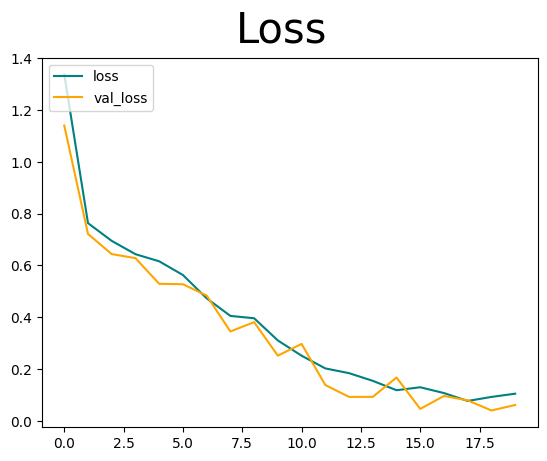

In [96]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("Loss", fontsize=30)
plt.legend(loc="upper left")
plt.show()

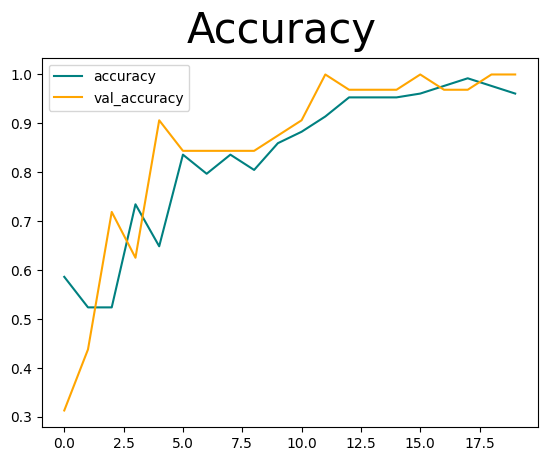

In [97]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="teal", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="orange", label="val_accuracy")
fig.suptitle("Accuracy", fontsize=30)
plt.legend(loc="upper left")
plt.show()

9. EVALUACIÓN DE LA RED NEURONAL.

In [98]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [99]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [100]:
#Este bucle se utiliza para evaluar el 
#modelo en el conjunto de prueba y actualizar las métricas para su posterior evaluación. 
#Itera todos los lotes del pipeline, realiza predicciones y actualiza las métricas con los
#valores reales vs las predicciones.

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 137ms/step


In [103]:
print(f"Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}")

Precision: 1.0, Recall:1.0, Accuracy:1.0


10. PRUEBAS

In [ ]:
#import cv2

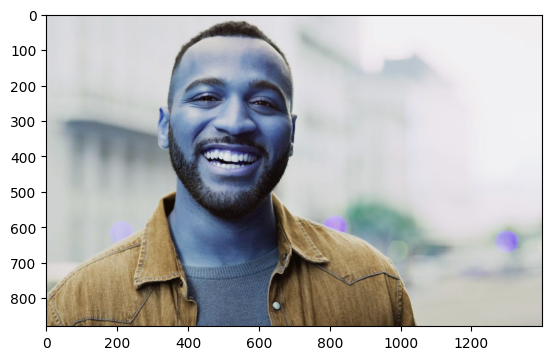

In [129]:
#Vamos a probar el modelo con imágenes nunca antes vistas.
img = cv2.imread("imagenfeliz-prueba.jpg")
plt.imshow(img)
plt.show()

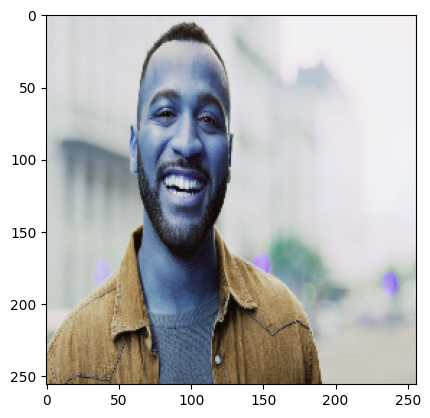

In [130]:
#El modelo tiene unas restricciones en la entrada.
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [131]:
#Nuestro modelo espera recibir un batch de imágenes y no una imagen individual.
#Con esta función, encapsulamos la imagen para poder utilizarla, además de escalar la imagen.
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 20ms/step


In [132]:
if yhat > 0.5:
    print(f"La imagen es de alguien triste.")
else:
    print(f"La imagen es de alguien Feliz")

La imagen es de alguien Feliz


In [112]:
#La imagen se conserva en el umbral de su clasificación correcta. (Feliz (0))

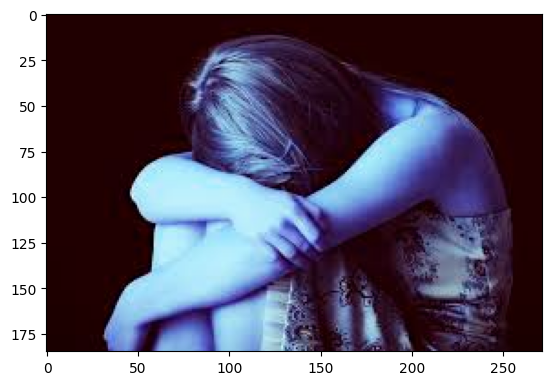

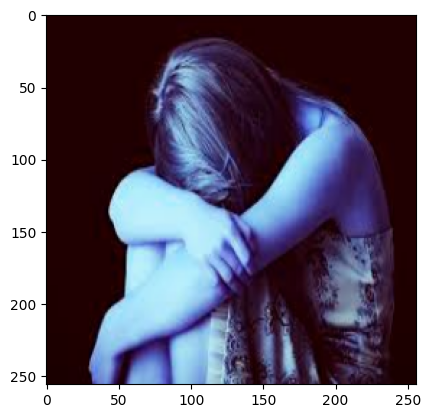

1/1 [==============================] - 0s 19ms/step


In [133]:
#Vamos a probar el modelo con imágenes nunca antes vistas.
img = cv2.imread("imagentriste-prueba.jpg")
plt.imshow(img)
plt.show()
#El modelo tiene unas restricciones en la entrada.
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()
yhat = model.predict(np.expand_dims(resize/255, 0))

In [134]:
if yhat > 0.5:
    print(f"La imagen es de alguien triste.")
else:
    print(f"La imagen es de alguien Feliz")
#La imagen se conserva en el umbral de su clasificación correcta. (Triste (1))

La imagen es de alguien triste.


11. GUARDAR EL MODELO

In [136]:
from tensorflow.keras.models import load_model

In [138]:
model.save(os.path.join("models","CNN-model-happy-sad-images.h5"))

C:\Users\Eo\Desktop\JupyterNotebooks\ImageClassification\imageclassification\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [140]:
new_model = load_model(os.path.join("models","CNN-model-happy-sad-images.h5"))

In [141]:
new_model

In [142]:
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 71ms/step


array([[0.9721705]], dtype=float32)

In [143]:
if yhat > 0.5:
    print(f"La imagen es de alguien triste.")
else:
    print(f"La imagen es de alguien Feliz")
#La imagen se conserva en el umbral de su clasificación correcta. (Triste (1))

La imagen es de alguien triste.
